<img  src="nb_images/yelp-logo.png" style="width:18%; hieght:20%;" align="left"/>

<h1>HELP</h1>

Machine learning for uncovering inisight in your business and market

Models/algorithms

nearest neighbor
naive Bayes
linear regression
ridge regression
logistic regression with and without regularization
softmax regression with and without regularization
linear discriminant analysis
quadratic discriminant analysis
Gaussian discriminant analysis
mixture models with latent variables (train with EM)
support vector machines and the kernel trick
decision trees
random forests
gradient boosted trees
XGBoost
neural networks
Kalman filter
AR, MA, ARMA, ARIMA time series models 
hidden Markov models (more coming on this)

 

Optimization/training tools:

stochastic gradient descent
Monte Carlo simulation (actually what we did is called rejection sampling)
expectation maximization

 

Model selection tools:

train and validation set.  holdout method
cross validation 
AIC/BIC
Bayesian model selection
ROC/AUC
out-of-bag estimates for random forests


Ideas and concepts to keep in mind:

overfitting
underfitting
loss functions
regulatization

 

Still coming (maybe):

More about methods for training hidden Markov Models
Markov chain Monte Carlo
Dimension reduction: SVD/PCA and Johnson-Lindenstrauss
Latent Dirichlet Analysis

In [487]:
from yelp_utils.data_manager import get_business_reviews, get_business_name
from yelp_utils.preprocess_reviews import tokenize, get_nouns
from pymongo import MongoClient
import nltk
import re

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

<h1 class='main_header'>Topic Modeling</h1>
<hr>

Within machine learning and natural language processing, a *topic model* is a type of statistical model for discovering abstract topics, or groups, that occur in a collection of documents. These topics are latent structures of the documents. The premise behind most of these models is that certain words will be more frequent in certain topics. For example, a document about sports is likly to contain the words "touchdown" and "runner", while a document about mathematics is much less likly to contain these words.

For the Yelp data we will use this genre of model in several ways:
 - Grouping similar reviews for a business
 - Finding similar business competitors
 - Discovering importatntant trends in reviews

<h2 class="section_header">Review Clustering</h2>

First, we will discover "documents" in the reviews. This can be interpreted as the different subjects and types of reviews users leave. Uncovering this latent structure could help a business see the categories that stand out to customers, for better of worse.

In [246]:
# Select the business
BIZ_ID = 'TWD8c5-P7w9v-2KX_GSNZQ'
print get_business_name(BIZ_ID)

Mandalay Bay Resort & Casino


In [152]:
# Make a list of reviews and stars
review_list = np.array([x['text'] for x in get_business_reviews(BIZ_ID)])
star_list = np.array([x['stars'] for x in get_business_reviews(BIZ_ID)])

In [242]:
print review_list[6]

Rum Jungle is a pretty amazing bar. Worth stopping by in the afternoon just to sit in and look at the decor and fountains. Glad I went.


In [241]:
# Tokenize those reviews so they can be processed
print tokenize(review_list[6])

[u'rum', u'jungle', u'is', u'a', u'pretty', u'amazing', u'bar', u'worth', u'stopping', u'by', u'in', u'the', u'afternoon', u'just', u'to', u'sit', u'in', u'and', u'look', u'at', u'the', u'decor', u'and', u'fountains', u'glad', u'i', u'went']


## Term Frequency-Inverse Document Frequency (Tf-idf)

After cleaning and tokenizing the text from reviews we can create teh term frequencey-inverse document frequency matrix.  This matrix counts the occurences of every important word in every document. Then like the picture bellow it stacks these vectors so the it is one matrix with the dimension (NUM_DOCUMENTS X VOCAB_SIZE).

<img src='nb_images/tf-idf.png'>

Once this matrix is created we then weight the words that occur frequently in the document but not in the corpus higher.

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [156]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(review_list)
vocab_list = tfidf_vectorizer.get_feature_names()

In [157]:
print(tfidf_matrix.shape)

(1859, 100)


From this we can see that we have 1859 reviews (aka documents) and a vocab size of 100. Now we can use this matrix to determine the distance between them in the 100 dimensional document space. The metric we will use for this is cosine similarity.

In [158]:
dist = 1 - cosine_similarity(tfidf_matrix)

## Clustering Documents

In [159]:
NUM_CLUSTERS = 4
k_means = KMeans(NUM_CLUSTERS)
k_means.fit(tfidf_matrix)
labels = np.array(k_means.labels_.tolist())

In [160]:
for i in range(NUM_CLUSTERS):
    print "Cluster %d: " % i
    print "-"*25
    print "Top Words: ",
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1] 
    for ind in order_centroids[i,:6]:
        print vocab_list[ind] + ", ",
    print "\nNumber of Reviews: %d" % np.sum(labels == i)
    print "Avg Stars: %d" % np.mean(star_list[labels == i])
    print "\n"

Cluster 0: 
-------------------------
Top Words:  hotel,  place,  great,  nice,  casino,  rooms,  
Number of Reviews: 673
Avg Stars: 3


Cluster 1: 
-------------------------
Top Words:  room,  hotel,  service,  stay,  time,  didn't,  
Number of Reviews: 531
Avg Stars: 2


Cluster 2: 
-------------------------
Top Words:  mandalay,  bay,  mandalay bay,  hotel,  stay,  vegas,  
Number of Reviews: 391
Avg Stars: 3


Cluster 3: 
-------------------------
Top Words:  pool,  lazy,  river,  lazy river,  wave,  wave pool,  
Number of Reviews: 264
Avg Stars: 3




##  Visualizing Clusters

By projecting these 100 dimensional vectors to 2 dimensional space with TSNE, we are able to see the clusters

In [247]:
from sklearn.manifold import MDS, TSNE

In [248]:
tsne = TSNE(n_components=2, n_iter=10000)
pos = mds.fit_transform(dist)

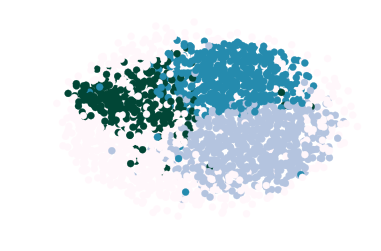

In [252]:
plt.scatter(pos[:,0], pos[:,1], c=labels, cmap=plt.cm.PuBuGn)
plt.axis('off')
plt.show()

<h2 class="section_header">Latent Dirichlet Allocation</h2>

LDA is a probabalistic topic model that assumes documents are a mixture of topics and each word in the document is atttributabe to the documents topics. This is useful because given 10 topics, a new topic can be assigned probabilities of being in each topic. By concatinating all the reviews for one business into a document we can then train this model to discover different types of businesses. This can be used to find similar reviews for a business or a businesses competitors by looking at the similarity of their topic distribution.

In [166]:
from gensim import corpora, models, similarities 
import pyLDAvis.gensim

In [180]:
#preprocess
tokenized_docs = [get_nouns(tokenize(x)) for x in review_list]

In [182]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [210]:
lda = models.LdaModel(corpus, num_topics=7, id2word=dictionary, 
                      update_every=5, chunksize=5, passes=6)

Ater looking at the words assosiated with the different topics I was able to label these groups.

In [234]:
topic_labels = [
    'Families and Groups',
    'Rooms and Physical Aspects',
    'Entertainment and Events',
    'Customer Service',
    'Pool and Casino',
    'Resturant at Water Show',
    'Transportation'
]

In [235]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (Families and Groups)
--------------------
i
everything
suite
kids
pool
family
part
conference
time
hotel
stay
life
river
room
mandalay
visit
husband
bay
call
party

Topic 1 (Rooms and Physical Aspects)
--------------------
room
bathroom
shower
floor
tv
bed
view
door
toilet
music
water
level
elevators
line
noise
hour
price
elevator
person
doors

Topic 2 (Entertainment and Events)
--------------------
show
people
table
business
ticket
work
reservations
nights
things
tickets
suite
bag
michael
jackson
wedding
problem
thank
years
venue
guy

Topic 3 (Customer Service)
--------------------
i
room
hotel
service
time
night
mandalay
desk
bay
front
valet
experience
customer
rooms
coffee
staff
morning
minutes
anything
manager

Topic 4 (Pool and Casino)
--------------------
pool
hotel
strip
mandalay
i
bay
rooms
casino
vegas
place
area
people
beach
check
resort
it's
hotels
pools
restaurants
time

Topic 5 (Resturant at Water Show)
--------------------
day
stay
line
days
fee
nothing
resort
h

In [212]:
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)

These topics perform very well in finding the latentent structure of areas of the business. One issue with this model is it is difficult to find the appropriate number of clusters for a new business.

## LDA For Multiple Businesses

Next we apply LDA to reviews from 5 different types of businesses. The goal of this is to discover these labels.

In [270]:
# Connect to database
client = MongoClient()
db = client.yelp

In [413]:
# Get examples from distinct businesses for training
different_categories = ['automotive', 'hair salons', 'pets', 'medical centers', 'butcher']

category_dict = {}
for category in different_categories:
    cursor = db.businesses.find({'categories':{'$in':[category]}}).limit(100)
    total_reviews = []
    for business in cursor:
        biz_reviews = [x['text'] for x in get_business_reviews(business['business_id'])]
        concat_biz_review = ' '.join(biz_reviews)
        cleaned_review = get_nouns(tokenize(concat_biz_review))
        total_reviews.append(cleaned_review)
    category_dict[category] = total_reviews

In [414]:
#preprocess
tokenized_docs = []
category_labels = []
for i, category in enumerate(different_categories):
    tokenized_docs += category_dict[category]
    category_labels += [i] * len(category_dict[category])

In [433]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(tokenized_docs)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=.05, no_above=0.6)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [434]:
lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, 
                      update_every=1, chunksize=100, passes=10)

In [435]:
lda.show_topics()

[(0,
  u'0.032*"bbq" + 0.029*"meat" + 0.027*"food" + 0.019*"brisket" + 0.016*"mac" + 0.016*"ribs" + 0.015*"pork" + 0.014*"beans" + 0.013*"vegas" + 0.013*"cheese"'),
 (1,
  u'0.025*"dog" + 0.016*"dogs" + 0.015*"staff" + 0.012*"store" + 0.012*"food" + 0.012*"service" + 0.011*"prices" + 0.008*"customer" + 0.007*"pet" + 0.007*"day"'),
 (2,
  u'0.019*"hospital" + 0.019*"staff" + 0.017*"care" + 0.014*"doctor" + 0.012*"room" + 0.011*"dr" + 0.010*"vet" + 0.009*"hours" + 0.008*"nurses" + 0.008*"office"'),
 (3,
  u'0.032*"car" + 0.017*"service" + 0.009*"work" + 0.007*"people" + 0.007*"insurance" + 0.007*"appointment" + 0.007*"minutes" + 0.007*"experience" + 0.006*"oil" + 0.006*"day"'),
 (4,
  u'0.062*"hair" + 0.027*"salon" + 0.021*"cut" + 0.014*"stylist" + 0.013*"haircut" + 0.012*"appointment" + 0.012*"color" + 0.010*"job" + 0.009*"years" + 0.009*"experience"')]

In [450]:
topic_labels = [
    'butcher',
    'pets',
    'medical centers',
    'automotive',
    'hair salons'
]

In [451]:
topics_matrix = lda.show_topics(formatted=False, num_words=10)
for topic_num, words in topics_matrix:
    print "\nTopic %s" % topic_num, "(" + topic_labels[topic_num] + ")" 
    print "-"*20
    for word in words:
        print word[0]


Topic 0 (butcher)
--------------------
bbq
meat
food
brisket
mac
ribs
pork
beans
vegas
cheese

Topic 1 (pets)
--------------------
dog
dogs
staff
store
food
service
prices
customer
pet
day

Topic 2 (medical centers)
--------------------
hospital
staff
care
doctor
room
dr
vet
hours
nurses
office

Topic 3 (automotive)
--------------------
car
service
work
people
insurance
appointment
minutes
experience
oil
day

Topic 4 (hair salons)
--------------------
hair
salon
cut
stylist
haircut
appointment
color
job
years
experience


Now that we have discovered these topics, given reviews for a business we can give the amount it belongs to each topic.

In [453]:
' '.join(all_reviews[0])

u"used to go there for tires brakes etc their prices have gone way up for mid-level tires for a toyota plus of the new tires went flat within weeks since they don t make appointments the wait to get the tire looked at was hours sorry--can't wait that long to get a warranted repair they lost my business for good"

In [454]:
lda[dictionary.doc2bow(all_reviews[0])]

[(0, 0.1250188690611381), (3, 0.74550391793766135), (4, 0.11561321254180351)]

In [449]:
accuracy = 0
for i, category in enumerate(different_categories):
    results = []
    num_category = len(category_dict[category])
    for review in category_dict[category]:
        doc_bow = dictionary.doc2bow(review)
        distribution = lda[doc_bow]
        percents = np.array([x[1] for x in distribution])
        max_indx = np.argmax(percents)
        results.append(distribution[max_indx][0])
    classes, amounts = np.unique(results, return_counts=True)
    print "Classes: %7s, Amount: %s" % (classes, amounts)

Classes: [1 2 3], Amount: [ 7  1 92]
Classes:     [4], Amount: [100]
Classes:   [1 2], Amount: [46 54]
Classes:   [2 3], Amount: [93  7]
Classes:   [0 3], Amount: [98  2]


<h1 class='main_header'>Sentiment Analysis</h1>
<hr>

Sentiment analysis is a branch of natural language processing that aims to systematically identify, extract, and quantify affective states and subjective information. The prototypical example is classifying if a review is positive or negative. For a bisunesses Yelp reviews we will use this so we can determine what is included in the most negative and most positive reviews. This can give concise information on what needs to be fixed and what is going well.

There are several teqniques for doing this...

<h2 class='section_header'>Naive Bayes</h2>

Because of the complex nature of working with text, historically the simple naive bayes model has been the standard for sentiment anaysis. The text is read in and then transformed into a simple bag of words. This gives the probability of words ocurring given a certain sentiment which is then used by naive bayes.

$$ P(c\vert x) = \frac{P(x\vert c)P(c)}{P(x)}$$
$$ P(c\vert x) = P(x_1\vert c) \times P(x_2\vert c)\times \dots P(x_n\vert c) \times P(c)$$

In [459]:
from yelp_utils.preprocess_reviews import prepare_classify
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [460]:
# Create trainging set of positive and negative examples
pos_list, neg_list = prepare_classify(700)
train = pos_list[:500] + neg_list[:500]
test = pos_list[500:] + neg_list[500:]

In [461]:
naiveBayes = NaiveBayesClassifier(train)

In [463]:
naiveBayes.show_informative_features()

Most Informative Features
         contains(Great) = True              pos : neg    =     32.3 : 1.0
      contains(terrible) = True              neg : pos    =     24.3 : 1.0
         contains(awful) = True              neg : pos    =     19.0 : 1.0
         contains(worst) = True              neg : pos    =     16.6 : 1.0
          contains(paid) = True              neg : pos    =     16.3 : 1.0
       contains(variety) = True              pos : neg    =     15.7 : 1.0
         contains(dirty) = True              neg : pos    =     15.0 : 1.0
        contains(pricey) = True              pos : neg    =     13.0 : 1.0
          contains(Rock) = True              pos : neg    =     11.8 : 1.0
         contains(liked) = True              pos : neg    =     11.7 : 1.0


In [467]:
naiveBayes.accuracy(test_set)

0.7375

<h1 class='main_header'>Automatic Summary</h1>
<hr>

In [469]:
from sumy.nlp import tokenizers
from sumy.parsers import plaintext
from sumy.summarizers import lex_rank

In [471]:
review_list = [x['text'] for x in get_business_reviews(BIZ_ID)]

In [480]:
concat_review = ' '.join(review_list[:100])

tokenizer = tokenizers.Tokenizer('english')    
parse = plaintext.PlaintextParser(concat_review, tokenizer)
doc = parse.document  
rank = lex_rank.LexRankSummarizer()

#Print the top ten results of the sorting
print('Ranked Sentences:')
print('------------------------------')
for i, sentence in enumerate(rank(doc, 10)):
    print('{}: {}'.format(i+1, sentence))
    print('\n')

Ranked Sentences:
------------------------------
1: I had a great time at Mandalay Bay!


2: The only negative I can come up with is that the hotel is located at the end of the Strip, so if you want to see something you will need to walk a lot.


3: It has it all.


4: It has it all.


5: it was great .


6: The pool at the Mandalay Bay is the best in Vegas.


7: The rooms are nice, not great but very good.


8: If you are all about hanging out by a pool, this is the hotel for you.


9: There's a bunch of good restaurants that you should try if you are staying there or not....Burger Bar which is in the Mandalay Bay Place is a must!


10: The only downfall on the Mandalay Bay is the location...it is located on the south strip...it's the last hotel on the south part of the strip so unless this is your first visit and you want to be more centralized so you can walk around and explore the strip, you might want to stay at this hotel during your return trips back.




<h1 class='main_header'>Time Series</h1>
<hr>

<h1 class='main_header'>Random</h1>
<hr>

<h2 class='section_header'>Product Sentiment</h2>

In [468]:
import graphlab as gl

In [482]:
review_objects = get_business_reviews(BIZ_ID)
reviews = [x['text'].encode('utf-8') for x in review_objects]
sf = gl.SFrame(reviews)

In [483]:
product_model = gl.product_sentiment.create(sf, features=['X1'])

Tokenizing...

TF-IDF transform...

Creating inverted index...

Creating query expansion model...

Saving data for querying...

In [484]:
product_model.get_most_positive()

__review_id,X1,sentiment_score
1467,Stay at Mandalay Bay &You Never Have to ...,1.0
1335,"Being a huge UFC fan, Ialways wanted to stay ...",1.0
501,My friends and I came toMandalay Bay in May for ...,1.0
1192,I've stayed on the MBayproperty approximately ...,1.0
140,My relationship withMandalay Bay is a love- ...,1.0
62,Mandalay Bay has been myfavorite place to sta ...,1.0
946,I am a local and myfamily was coming into ...,1.0
102,I absolutely loved myexperience here and I ...,1.0
541,This is my favoritebudget friendly hotel in ...,1.0
799,I recently stayed atMandalay Bay during my ...,1.0


In [485]:
product_model.sentiment_summary(keywords=['fish'])

keyword,sd_sentiment,mean_sentiment,review_count
fish,0.0884981417545,0.959784765798,10


In [486]:
product_model.review_searcher.query('Cr\xc3\xa8me Brulee', num_results=50)

score,__review_id,X1,sentiment_score
17.9381183128,789,The room service crèmebrûlée was the best we ...,0.918700471766


[{u'_id': u'4bEjOyTaDG24SY5TxsaUNQ', u'count': 5558},
 {u'_id': u'lliksv-tglfUz1T3B3vgvA', u'count': 2911},
 {u'_id': u'CZjcFdvJhksq9dy58NVEzw', u'count': 2832},
 {u'_id': u'tFU2Js_nbIZOrnKfYJYBBg', u'count': 2781},
 {u'_id': u'6LM_Klmp3hOP0JmsMCKRqQ', u'count': 2551},
 {u'_id': u'eWPFXL1Bmu1ImtIa2Rqliw', u'count': 2459},
 {u'_id': u'DO3Gk17RyJVW7zYMCtYPnw', u'count': 2369},
 {u'_id': u'jf67Z1pnwElRSXllpQHiJg', u'count': 2345},
 {u'_id': u'34uJtlPnKicSaX1V8_tu1A', u'count': 2253},
 {u'_id': u'NGJDjdiDJHmN2xxU7KauuA', u'count': 2081},
 {u'_id': u'xyTJYlbE_MLouK6rCou6zg', u'count': 2004},
 {u'_id': u'-7yF42k0CcJhtPw51oaOqQ', u'count': 1970},
 {u'_id': u'FV16IeXJp2W6pnghTz2FAw', u'count': 1921},
 {u'_id': u'SsTxjxo8qvqBMvan1rzNzg', u'count': 1875},
 {u'_id': u'TWD8c5-P7w9v-2KX_GSNZQ', u'count': 1859},
 {u'_id': u'G0nUhYF2q4tnoOPwCjXLig', u'count': 1815},
 {u'_id': u'u9wjRhUjySkHPa_hG3kFOg', u'count': 1746},
 {u'_id': u'hW0Ne_HTHEAgGF1rAdmR-g', u'count': 1709},
 {u'_id': u'ripCiWZ0MblMZSLrIKQAKA', u'count': 1698},
 {u'_id': u'HbUQ_3dlm3uCacmhTEMnuA', u'count': 1651},
 {u'_id': u'_v6HIliEOn0l0YaAmBOrxw', u'count': 1621},
 {u'_id': u'JokKtdXU7zXHcr20Lrk29A', u'count': 1610},
 {u'_id': u'VVeogjZya58oiTxK7qUjAQ', u'count': 1578},
 {u'_id': u'tqu42L0qXzkvYKSruOz0IA', u'count': 1551},
 {u'_id': u'bYhpy9u8fKkGhYHtvYXazQ', u'count': 1478},
 {u'_id': u'DUdBbrvqfaqUe9GYKmYNtA', u'count': 1459},
 {u'_id': u'WT-v-DgQvW38DewVyTLdTA', u'count': 1416},
 {u'_id': u'aRkYtXfmEKYG-eTDf_qUsw', u'count': 1390},
 {u'_id': u'eLPld7Q17XxlclFGzZQX5g', u'count': 1372},
 {u'_id': u'8IMEf_cj8KyTQojhNOyoPg', u'count': 1369},
 {u'_id': u'SLyacGZuMUKqrQJEooSkjw', u'count': 1299},
 {u'_id': u'KjymOs12Mpy0Kd54b7T9MA', u'count': 1293},
 {u'_id': u'HMr_KN63f6MzM9h8Wije3Q', u'count': 1291},
 {u'_id': u'OUpcKYGbVYgSS1Oo7aQ56Q', u'count': 1261},
 {u'_id': u'8buIr1zBCO7OEcAQSZko7w', u'count': 1216},
 {u'_id': u'3Q0QQPnHcJuX1DLCL9G9Cg', u'count': 1188},
 {u'_id': u'4UVhuOLaMm2-34SrW8y-ag', u'count': 1162},
 {u'_id': u'ynK2ljcx5S1qSxouBrN5Xg', u'count': 1160},
 {u'_id': u'YacTpiq0ZptFcXD7I-kdGA', u'count': 1148},
 {u'_id': u'K8pM6qQdYu5h6buRE1-_sw', u'count': 1110},
 {u'_id': u'FHqwLwpLjUjeLP-IdG_o_w', u'count': 1096},
 {u'_id': u'ASOiJ8MmbBTgK2D1_MQrqg', u'count': 1090},
 {u'_id': u'Q_Rwcv9APBLggk2KAsBEvg', u'count': 1083},
 {u'_id': u'SDwYQ6eSu1htn8vHWv128g', u'count': 1067},
 {u'_id': u'KJnVuzpveyDrHARVNZaYVg', u'count': 1025},
 {u'_id': u'm7icEOgYpM3B8TlbYsKPzg', u'count': 1022},
 {u'_id': u'Zx8_4zKdDBSO3qGrkukBIA', u'count': 1021},
 {u'_id': u'Z0kyK8wCBNGkkUT9UrMWcg', u'count': 973},
 {u'_id': u'L9UYbtAUOcfTgZFimehlXw', u'count': 968},
 {u'_id': u'ES-j5yNTgmgbL4He0h6otA', u'count': 966},
 {u'_id': u'65EJzWvIUnE1YwpfW6Jl1Q', u'count': 907},
 {u'_id': u'tbTc7094zwIYAtU-0NkU4w', u'count': 864},
 {u'_id': u'1NZLxU5WvB5roPFzneAlLw', u'count': 857},
 {u'_id': u'c1yGkETheht_1vjda7G5sA', u'count': 843},
 {u'_id': u'Q4ULAiIE2qCA4RYplCTrUQ', u'count': 836},
 {u'_id': u'QJlab4DqvBRJPUfg7Vn5ZQ', u'count': 830},
 {u'_id': u'RbkLrCFa2AL1K25GCnNK8A', u'count': 830},
 {u'_id': u'f3EcPjqKftEznBSs2oQVRg', u'count': 803},
 {u'_id': u'z3yFuLVrmH-3RJruPEMYKw', u'count': 791},
 {u'_id': u'OFBJtqWGSx6n6CchtVmoRw', u'count': 782},
 {u'_id': u'q_DrPmiLrHEpR_SQvQXELQ', u'count': 781},
 {u'_id': u'i3ogCoQD4MY_sR73GCk-BA', u'count': 774},
 {u'_id': u'DqY2VlbRuQ3Mu2mlxd4xUQ', u'count': 755},
 {u'_id': u'Zf7fMSe7yuW727JyikdBsg', u'count': 751},
 {u'_id': u'PqTX5j9yfsPbd1qQCA1EwA', u'count': 739},
 {u'_id': u'yD1dRYi7USzhYVKiqZ7JVg', u'count': 734},
 {u'_id': u'n5eQnMnVVt3FfrFENYoU0g', u'count': 733},
 {u'_id': u'UEUQS4z7s-DRzQjky92KYw', u'count': 725},
 {u'_id': u'Ensu96ecI0OReupNS2x7ig', u'count': 724},
 {u'_id': u'fkVBloMEFJG2HTgeCxeNDg', u'count': 720},
 {u'_id': u'H6CJflwclNpttYrtsBMsVg', u'count': 714},
 {u'_id': u'AkOruz5CrCxUmXe1p_WoRg', u'count': 706},
 {u'_id': u'APe_0I6DqbNQonSlEkMSEQ', u'count': 696},
 {u'_id': u'CrlViaCIcMeQuZc63tbdQA', u'count': 694},
 {u'_id': u'gkWEjZIVcrUerEzed6IKpg', u'count': 693},
 {u'_id': u'Yq8LiVymGA7vBpGCQuDfRw', u'count': 688},
 {u'_id': u'1bJjWGYip-V2PGj4VIwbiQ', u'count': 669},
 {u'_id': u'lAher1puKzN9r3LALx-JqQ', u'count': 669},
 {u'_id': u'lddbHJKgFvnVWabK-M8TPA', u'count': 663},
 {u'_id': u'Pgp3gbOQaJIdyjqC9AOz6g', u'count': 660},
 {u'_id': u'9Y3aQAVITkEJYe5vLZr13w', u'count': 657},
 {u'_id': u'mxrXVZWc6PWk81gvOVNOUw', u'count': 656},
 {u'_id': u'bwu0cUZfksuu-uzTPrrl2A', u'count': 652},
 {u'_id': u'rMSje59v2QY82OBvE1zBuA', u'count': 647},
 {u'_id': u'R8VwdLyvsp9iybNqRvm94g', u'count': 641},
 {u'_id': u'EKzMHI1tip8rC1-ZAy64yg', u'count': 630},
 {u'_id': u'bmNPNlCLDplWB55ic3Bixg', u'count': 627},
 {u'_id': u'co0vxQ8ecXiBy2sGDeHi8A', u'count': 626},
 {u'_id': u'eoDEx1GGQA0CBDhy2ql_Kw', u'count': 615},
 {u'_id': u'_VN5hYv1VgNIBgwxTQZ_1Q', u'count': 614},
 {u'_id': u'fkacCsAiwXYQzdlaQZm0Gg', u'count': 611},
 {u'_id': u'FV0BkoGOd3Yu_eJnXY15ZA', u'count': 596},
 {u'_id': u'mpDxBBGywUE6GRRKja3sBA', u'count': 590},
 {u'_id': u'b5cEoKR8iQliq-yT2_O0LQ', u'count': 587},
 {u'_id': u'cN6aBxe2mQvrQlzk26LyRQ', u'count': 577},
 {u'_id': u'KwLfgeylp9d8zY3KacREiw', u'count': 563},
 {u'_id': u'G69-uLxHs3h6uvrikivpVA', u'count': 558},
 {u'_id': u'gu5Yj92bnXnxNyMdxO14VA', u'count': 555},
 {u'_id': u'4GQhbPvGU5r23YdVm8EmkQ', u'count': 552},
 {u'_id': u'2ceeU8e3nZjaPfGmLwh4kg', u'count': 551},
 {u'_id': u'rDvz5jX65gpfONFu7er9Tw', u'count': 551},
 {u'_id': u'xxOQ7h6s3InV8o8DOVHlMA', u'count': 550},
 {u'_id': u'foDMwBRGJvKw791v0AT7OA', u'count': 549},
 {u'_id': u'6oRAC4uyJCsJl1X0WZpVSA', u'count': 549},
 {u'_id': u'jh7S78tc9oXCDjAjP_OrLw', u'count': 544},
 {u'_id': u'bqYrEwL5xjqv0u8XAij--Q', u'count': 542},
 {u'_id': u'w4SGmsvFzqyAIs7CSQ_J-g', u'count': 540},
 {u'_id': u'WhBxWYRj6rycigYqdXY9cA', u'count': 538},
 {u'_id': u'uYVdp5LfCbX8S8ytnhdk-g', u'count': 533},
 {u'_id': u'tb24fvNJfHhyKEXkKn12Xw', u'count': 530},
 {u'_id': u'W0TK5K3VLbnNrrzLTaaykw', u'count': 527},
 {u'_id': u'dcd3C1gWv-vVdQ9XYV8Ubw', u'count': 526},
 {u'_id': u'qMkIbQFrROSnPaQ7at85-w', u'count': 521},
 {u'_id': u'wZwZcte4lcbu51NOzCjWbQ', u'count': 519},
 {u'_id': u'JhupPnWfNlMJivnWB5druA', u'count': 516},
 {u'_id': u'keV-NU5jaemf9L_7HDX-OA', u'count': 510},
 {u'_id': u'SMpL3z4FLF07bRA6-y22JQ', u'count': 506},
 {u'_id': u'-vVQyTVHitF6TOHGijVXxQ', u'count': 505},
 {u'_id': u'ZgWUM594Yqk52IvBgoIrdA', u'count': 502},
 {u'_id': u'UKKz4HdQC0aH9j5lLi4u8Q', u'count': 496},
 {u'_id': u'E4AkhjuG-DY2DTcBrkxkGg', u'count': 490},
 {u'_id': u'4EhFsjWBSaSp_5TkkLp7LA', u'count': 487},
 {u'_id': u'PPwJTT-eLjapipmyQSgi9A', u'count': 480},
 {u'_id': u'TKE1cyjs9q2PoqMXqEV9Eg', u'count': 478},
 {u'_id': u'5kRug3bEienrpovtPRVVwg', u'count': 478},
 {u'_id': u'PayaNmMeZFOFeS_jo7eB8g', u'count': 468},
 {u'_id': u'5IWu0xhlZEopvIz3w7o_3w', u'count': 466},
 {u'_id': u'rP76z9iDOFczywAiee-l7A', u'count': 465},
 {u'_id': u'mmuBeBJIVRjMwcc08RG_cw', u'count': 464},
 {u'_id': u'fWnGkLnZzv2yl3fB7xF40g', u'count': 463},
 {u'_id': u'jJhNOhuGpIsJX5SEUFFWYQ', u'count': 463},
 {u'_id': u'bA-Cj6N9TEMlDlOh2aAnUw', u'count': 463},
 {u'_id': u'd52zg-S0o940WUCK-nNiKw', u'count': 462},
 {u'_id': u'bpGFetX8muk0GxAT3Oea3Q', u'count': 460},
 {u'_id': u'KPoTixdjoJxSqRSEApSAGg', u'count': 456},
 {u'_id': u'LzNJLEIo4gh-X_rmDkNkNg', u'count': 454},
 {u'_id': u't1sCvl0nSbWeRj0ZgsolRA', u'count': 452},
 {u'_id': u'YZuHOgbKiP3dN4_ROOUyDQ', u'count': 451},
 {u'_id': u'lqx--hrRwe0oK6WnFYNXlg', u'count': 451},
 {u'_id': u'vvur3WRgdgnhYoMUXMZZCA', u'count': 447},
 {u'_id': u'3rwM9fPYPk9qDkEBOhyHbg', u'count': 443},
 {u'_id': u'V6BYjHM9SnXscfkln3hCdA', u'count': 442},
 {u'_id': u'zMa6YoEekpABg1HZnnTZdg', u'count': 442},
 {u'_id': u'aLWvaNTOUr1wdOizitoOuA', u'count': 436},
 {u'_id': u'4AKcmN--0hbF0kX9pg8scg', u'count': 436},
 {u'_id': u'zuqsWG_FamUP3FQnL49Q4Q', u'count': 428},
 {u'_id': u'7QSYBp2-AOdyUJXEaLnbgA', u'count': 428},
 {u'_id': u'0UZ31UTcOLRKuqPqPe-VBA', u'count': 426},
 {u'_id': u'UBvTnbaRD3h_dD6oXWLCBA', u'count': 426},
 {u'_id': u'sXEOGcIGsO2_zZXYxVadTw', u'count': 426},
 {u'_id': u'NeUf9FyCCIN4MEseNyqkXQ', u'count': 425},
 {u'_id': u'DxUn-ukNL27GOuwjnFGFKA', u'count': 424},
 {u'_id': u'iNT6pcUugoXsDlZgRTyhtw', u'count': 421},
 {u'_id': u'oCA2OZcd_Jo_ggVmUx3WVw', u'count': 421},
 {u'_id': u'8_HGHlHsNdCnTsLQYHteAw', u'count': 420},
 {u'_id': u'6md4A90THda31wTg1bB3hg', u'count': 418},
 {u'_id': u'luCSjoNQ9q_0QIjKKOy2pQ', u'count': 416},
 {u'_id': u'cjD2yGRhT5yaSj_KP55Ptw', u'count': 416},
 {u'_id': u'Bp93pemXBdiEkZqdK-vtgw', u'count': 414},
 {u'_id': u'-AAig9FG0s8gYE4f8GfowQ', u'count': 414},
 {u'_id': u'Zy2vca7i9QFGRKa4m0C__A', u'count': 413},
 {u'_id': u'uR2aNW75R4oYs9w7aw-_kQ', u'count': 411},
 {u'_id': u'HT-3izSFU8ZMazvSqrADyw', u'count': 411},
 {u'_id': u'y6sNNP97UCSl_p2o5Wm40A', u'count': 409},
 {u'_id': u'bQXzuRIQNKGxe0Py-CLDYA', u'count': 409},
 {u'_id': u'8Hn5X1AqgmSLHRG2KgBJBg', u'count': 407},
 {u'_id': u'rG_8t33D2ADcbBqcXqwV0Q', u'count': 406},
 {u'_id': u'bc-lE-wGVAsUrX-kJhtY-Q', u'count': 404},
 {u'_id': u'uE8UZzb8xMMULary5sXHpQ', u'count': 403},
 {u'_id': u'VZyE9u5-gAG62zfe53hXWA', u'count': 402},
 {u'_id': u'dNsKB5LA2Mf8BDqTS_FAIA', u'count': 402},
 {u'_id': u'TwxHMCcRdF_CQb_EZ6kPQQ', u'count': 402},
 {u'_id': u'kFVapB4z_5VoOnYazF_ERA', u'count': 401},
 {u'_id': u'-KDCNt72VIuhV1rSUlF-eg', u'count': 400},
 {u'_id': u'1bnte8O-rO_RcRlp9y2u7Q', u'count': 396},
 {u'_id': u'5FPU_0VSLtR2yY7IQzaH5g', u'count': 394},
 {u'_id': u'upmnxJvYe5aOYE9wVNkGaw', u'count': 393},
 {u'_id': u'X0cEpOYi0Gf-S_-xb8OZVQ', u'count': 392},
 {u'_id': u'cVejKU_SrdbvzIbQ4oPV0A', u'count': 391},
 {u'_id': u'Snp5LyDO9NeQiuFPOlkavw', u'count': 390},
 {u'_id': u'J3A5V0Hl07o_KQSI2hHf_g', u'count': 388},
 {u'_id': u'sxRI0je6hAR-MeBDxdyhug', u'count': 388},
 {u'_id': u'MLPEpxih9E8NySHbM0FSWQ', u'count': 386},
 {u'_id': u'L2J3JfjXZLnX1rLhWKthqA', u'count': 386},
 {u'_id': u'SkcccvAydbt5zlQI0EUL2g', u'count': 385},
 {u'_id': u'5tYLVPc2PKnj6E62sY6QMg', u'count': 384},
 {u'_id': u'SoCQmHKJz54E09tEhmzwcQ', u'count': 377},
 {u'_id': u'6qXQQOWdUZiJmWVqkWB-3w', u'count': 376},
 {u'_id': u'ROQQk4mCm4_tebvTEGjhEQ', u'count': 375},
 {u'_id': u'18TUn9oiW0k0yB6lheiOvw', u'count': 374},
 {u'_id': u'N8Q2s-Snz2vL79zB3rEEug', u'count': 370},
 {u'_id': u'fjaQ3Ixkofh8xGhklUtDnA', u'count': 370},
 {u'_id': u'bB1bVvOMkfvWFVbNmRl_VA', u'count': 363},
 {u'_id': u'G9LwkTSdKOyOGqd5BbuIkA', u'count': 362},
 {u'_id': u'ML1RJdeZ7bbfMrHvJ7m99A', u'count': 359},
 {u'_id': u'xhh72bIFefOaAxsj4vJJaA', u'count': 358},
 {u'_id': u'33aOj9haiHsULCUmFOZ7uQ', u'count': 358},
 {u'_id': u'fF6m3qsD5blnwuZRuYhzWg', u'count': 357},
 {u'_id': u'Nj6ITW0Zhl7LpovGIH6SAg', u'count': 357},
 {u'_id': u'NfdZgoNTGsfth9MS8Qaurg', u'count': 357},
 {u'_id': u'V3ruBXjLGWniPNPQOzRhiw', u'count': 357},
 {u'_id': u'1ldDbggHHgPlj3k0SpBTKQ', u'count': 357},
 {u'_id': u'2Dbg35sPSGmZGcbBVNa9dA', u'count': 355},
 {u'_id': u'vvPzcOhbQn5fLQUAIxcP6A', u'count': 354},
 {u'_id': u'cE16HnvfgpTAk2GW3mF4Aw', u'count': 353},
 {u'_id': u'UpkfQApZT5rctZicZ_ZTgw', u'count': 353},
 {u'_id': u'P5uC-zfGG6yqoQDUyqyAvg', u'count': 352},
 {u'_id': u'eGevCRobYnA_HSj60sEWvQ', u'count': 351},
 {u'_id': u'GIGI8bJfN6HyPzmEW-QqjA', u'count': 350},
 {u'_id': u'cMBZ46gNJPYY7zkxDb1piw', u'count': 347},
 {u'_id': u'DoEMzev54WS8_lVLJ3NoqQ', u'count': 346},
 {u'_id': u'UI8iKvzhGn2qZCGIqtQqrQ', u'count': 346},
 {u'_id': u'2OY8xs4aqOt8eTnYokdrww', u'count': 346},
 {u'_id': u'jBb5KHHAj4s8hcXVS6QXDg', u'count': 345},
 {u'_id': u'jTGQUWGIVvL-aY03C5BEmw', u'count': 345},
 {u'_id': u'ecpYgTTQuXzmYNGxGTvbhw', u'count': 344},
 {u'_id': u'Hdi7jkB7pHiM1nyPHcqSdw', u'count': 344},
 {u'_id': u'1Ap6ZNCvyLLKHP0wvCk9yA', u'count': 344},
 {u'_id': u'6AzXPSXxztBnGwkToG3jKg', u'count': 341},
 {u'_id': u'woeY1YUkcaXgx6CzWqhATw', u'count': 341},
 {u'_id': u'zFcd_gelAUEwAvJOgiZpvg', u'count': 340},
 {u'_id': u'88CNSyeoKhGn1x0SHvz8Ig', u'count': 339},
 {u'_id': u'-3WVw1TNQbPBzaKCaQQ1AQ', u'count': 338},
 {u'_id': u'x_MCZPQ9G-IsDnwkJBceIQ', u'count': 338},
 {u'_id': u'2nzUx_M8Szyzsf4CszHasw', u'count': 337},
 {u'_id': u'pNyqk-HCo3SXPPppi04Bag', u'count': 336},
 {u'_id': u'bzSzpGAn4kjGRtsgMM1pvg', u'count': 335},
 {u'_id': u'_UsqOvmgoNzb_0xWpzwZBg', u'count': 333},
 {u'_id': u'OvE1oiSg9gaB9cLGzBPlnw', u'count': 331},
 {u'_id': u'9IbQxDmWBG2t8w9nw9VgEA', u'count': 329},
 {u'_id': u'mU57qypB4nLScxgowHNEUA', u'count': 327},
 {u'_id': u'8lLkZOfXbSMumZC-v08GaA', u'count': 327},
 {u'_id': u'EH7sT3dV-B365RETWCQhIA', u'count': 326},
 {u'_id': u'r70nuDpkR5-g1oShW2ANvA', u'count': 324},
 {u'_id': u'YuS7tA9VkXwgywis4TMspg', u'count': 323},
 {u'_id': u'fEX1IcPNrhJAdwk4DgyVVw', u'count': 323},
 {u'_id': u'RfR5yc4j9coIPBuxRsOW8Q', u'count': 323},
 {u'_id': u'Exx5ffvnmk4MrTyCkPRuug', u'count': 321},
 {u'_id': u'8Nsh8u0zHYegI6XT1L39Lg', u'count': 320},
 {u'_id': u't0yVlH_n9_eEZskHwr5cnQ', u'count': 320},
 {u'_id': u'mCUKDoJdHLF4f1tGT9xC0g', u'count': 320},
 {u'_id': u'P3z-tSjqJRMJPQ9fx_5MSQ', u'count': 319},
 {u'_id': u'SfrHdU4NCkYWvERnWaOUqQ', u'count': 319},
 {u'_id': u'kEsKrIJ6M1KOb8UALrpP7g', u'count': 319},
 {u'_id': u'-bd26a1QEEpqUZjBmtBUiQ', u'count': 318},
 {u'_id': u'3xEB9FyFXolq1b_Qn_BFtg', u'count': 318},
 {u'_id': u'Ss7rZpNaKRWs4Wkq_tHuTA', u'count': 317},
 {u'_id': u'dimWYHJ7U21GQziojKH0xg', u'count': 317},
 {u'_id': u'7_zL7NX_rDFwhbLp98PwZg', u'count': 317},
 {u'_id': u'o1GIYYZJjM6nM03fQs_uEQ', u'count': 316},
 {u'_id': u'IM-9thHqQbBK5tX5MfTzBQ', u'count': 316},
 {u'_id': u'1Duul3qCnLrNak1Np-iHfw', u'count': 312},
 {u'_id': u'pF7uRzygyZsltbmVpjIyvw', u'count': 309},
 {u'_id': u'l2rEBS7iKgIteBe0KgB5Ng', u'count': 308},
 {u'_id': u'xtX2qS64zP2NRPV_7NNqHw', u'count': 307},
 {u'_id': u'Dq6g0ubf267tWRU4BSk44A', u'count': 307},
 {u'_id': u'aidjBZ-cLeRmrsAPM6ZkcA', u'count': 306},
 {u'_id': u'LMG0zsAkUSscIvmV9vvm3A', u'count': 305},
 {u'_id': u'3Zsjlum5kl5N5KV712aTMQ', u'count': 304},
 {u'_id': u'sNuyncpQdcvfEpfZS-3Yew', u'count': 303},
 {u'_id': u'0vzZ_Bcb02rJljeMU9XkBw', u'count': 303},
 {u'_id': u'O_ZNZDr6c5CsK6GgsKdDeQ', u'count': 302},
 {u'_id': u'9tSHBEoAhKu-tkU8n6SKjA', u'count': 301},
 {u'_id': u'7WGBi29_vj_7RcPVxpLNHA', u'count': 301},
 {u'_id': u'DKY2be7dDX2CT_WB_Dk4pQ', u'count': 300},
 {u'_id': u'0udEgNqy5rLR5pZ4kD19Og', u'count': 300},
 {u'_id': u'BESmH-lmMm34_EefL8X9fQ', u'count': 299},
 {u'_id': u'MLcXtnpzygZvQ9BtseLLlw', u'count': 299},
 {u'_id': u'Cp6JGY5YIRncTV_My9nf9g', u'count': 299},
 {u'_id': u'_tkAI5Q5XQSfgbqJzDKSDQ', u'count': 297},
 {u'_id': u'Y606ZDAYwBug3CUwgHZQZA', u'count': 297},
 {u'_id': u'YZxA6w82eFJFntwqJLln6w', u'count': 297},
 {u'_id': u'd3-h8QpXoQnUlC9nt55HTw', u'count': 297},
 {u'_id': u'AwD1zOOhuCAbAPSaZ4X68Q', u'count': 296},
 {u'_id': u'NTfUFk8GyOLL1uPbEO-pVg', u'count': 294},
 {u'_id': u'un3KC2gyMrSG6yqjVRctXg', u'count': 293},
 {u'_id': u'c0RSs2KYK5Y-ZlSrNq9LyA', u'count': 293},
 {u'_id': u'nQUsMhT7qY6pPMvTT6xGcQ', u'count': 293},
 {u'_id': u'soiGohHtWOltGeomkSxzEw', u'count': 293},
 {u'_id': u'5FE1Y9cZ-YOQA943nTi7cA', u'count': 292},
 {u'_id': u'fK7ujDbjhRFEe2D7eIwK4w', u'count': 292},
 {u'_id': u'XmdTkxKyJd7TuDLoiic1kg', u'count': 291},
 {u'_id': u'HMUvbAHRnbAczNrYy8e5MA', u'count': 290},
 {u'_id': u'TuarWzZ4ITf3H7vkPrz-Kw', u'count': 289},
 {u'_id': u'DlCtdbceo4YNSI53cCL2lg', u'count': 287},
 {u'_id': u'EnKI5w-x0_ZPAS_3QPYFtQ', u'count': 286},
 {u'_id': u'uSbUk-3UcgzTPpzyL9dgJQ', u'count': 285},
 {u'_id': u'hMX4U1Ie3_PLCOQM2-BnDQ', u'count': 285},
 {u'_id': u'dS5qlJ6au0Wz9FwmbPSjYA', u'count': 285},
 {u'_id': u'438avb8WSYIKFn77dtsFow', u'count': 284},
 {u'_id': u'jEWfxxA_kjeJE_Z_ku3zLA', u'count': 283},
 {u'_id': u'qkc9xYbOFDLhPyA6Kdr8lQ', u'count': 283},
 {u'_id': u'y75baZnoI51J8WS7NK9FHQ', u'count': 283},
 {u'_id': u'8Z3jgKCdfp57PvT1AFOWtg', u'count': 280},
 {u'_id': u'secsGLdQOaJPATB9SnHlew', u'count': 280},
 {u'_id': u'3UMcsN9IjoeV8JZvC4apag', u'count': 280},
 {u'_id': u'4MwbNHAVZ6aRE1FWks-HRQ', u'count': 279},
 {u'_id': u'jJlOPkv4Xl6vxNzr51fnYw', u'count': 279},
 {u'_id': u'zMN8UGd1zDEreT58OCdnyg', u'count': 278},
 {u'_id': u'UO80ofDOenKF4QWR2z-oKA', u'count': 278},
 {u'_id': u'OVtSFFNohXIz9vdWDvbnEw', u'count': 278},
 {u'_id': u'dl5K9Hc2kUcGcrVIQAOhWQ', u'count': 277},
 {u'_id': u'0db71MbrvcJnyk71COCJBg', u'count': 277},
 {u'_id': u'I941jBn1KURuN-2wygJ_5A', u'count': 274},
 {u'_id': u'WUtPI9rJbs7ET1gPhULnDw', u'count': 273},
 {u'_id': u'auorqdHiATGZHVd-sd79ZQ', u'count': 272},
 {u'_id': u'9Vr8jxyP6eP9HQcEbg1awg', u'count': 272},
 {u'_id': u'jCOTob1avPH52RNuniylkg', u'count': 272},
 {u'_id': u'QvRK2dyv4EDxuJ-LuodE2Q', u'count': 269},
 {u'_id': u'Bjt3rB73dvSDe1XEPEWc6w', u'count': 269},
 {u'_id': u'VpW40mznMS43CqdbelX2wA', u'count': 269},
 {u'_id': u'e5kc0CQ4R-PCCDgb274gSg', u'count': 268},
 {u'_id': u'iNvY0zAlaD_ye7Z6rHu-Ug', u'count': 268},
 {u'_id': u'fjRBF1-0JlJoxH5_jDANgA', u'count': 266},
 {u'_id': u'5yMcbS15CfhSvVQWCe79tw', u'count': 265},
 {u'_id': u'Pfb6VOIiroqDWOebfgWGPQ', u'count': 265},
 {u'_id': u'2X5G4Ujq0s4Wfn4TC7gX0g', u'count': 265},
 {u'_id': u'E28ht8IEiO6FZbKktSo0Xw', u'count': 264},
 {u'_id': u'FOfhEC6rN23RQaUlsR2byw', u'count': 264},
 {u'_id': u'IMGW6y8wHQCfr_6k-YXg_A', u'count': 264},
 {u'_id': u'vgXE1I7c9ElcfYyZfQiN1Q', u'count': 264},
 {u'_id': u'2SwC8wqpZC4B9iFVTgYT9A', u'count': 263},
 {u'_id': u'fVgrpVyp-nPLTac9YIjTug', u'count': 263},
 {u'_id': u'EHi-lebXGWjSktl4WvSoow', u'count': 262},
 {u'_id': u'J_3Z0OhfTe90vCG1ThaK_g', u'count': 262},
 {u'_id': u'k6Si433-EJrY4J7SZxsnjA', u'count': 261},
 {u'_id': u'3MIy-ca6QVtKWXNzerQxWw', u'count': 261},
 {u'_id': u'pPJyi5kggzTibTxSPuRd0g', u'count': 261},
 {u'_id': u's8cHXeSlX_aPI2x49UkCCg', u'count': 261},
 {u'_id': u'X453V4J1EayCam-DU9d4LQ', u'count': 260},
 {u'_id': u'UWPQelWfvXOFpFQXTsVzow', u'count': 260},
 {u'_id': u'QdbZyl-LWFS54u93Vjd5SA', u'count': 260},
 {u'_id': u'_3f8o37w8APyUboCgwPkhA', u'count': 259},
 {u'_id': u'gwCWL6Vc9imaTNNpO7sfFg', u'count': 259},
 {u'_id': u'vAOTGsBMJp2ebRCJ6Ny7NQ', u'count': 258},
 {u'_id': u'lzoTXcynmfZ6Ler5B4HbfQ', u'count': 258},
 {u'_id': u'JMOK_Sy6aSOZwd4qgkX7hg', u'count': 256},
 {u'_id': u'CChwRoYVXA3QZulS8a6xOQ', u'count': 256},
 {u'_id': u'RGmR2iBzqI3LEMDE6J8nJA', u'count': 255},
 {u'_id': u'24Qlwel3zvrkNX9zMvBJDg', u'count': 255},
 {u'_id': u'xPmY3FNTym7gHdWcW7VxrA', u'count': 254},
 {u'_id': u'tQQxehL2ZVGp7MqAxtSU_g', u'count': 254},
 {u'_id': u'MQnNtW1lHS-eid3QNUoUIw', u'count': 254},
 {u'_id': u'6dIZ2hjHfjV2ZaxS2H-fcw', u'count': 254},
 {u'_id': u'Ca-003BAqWW-IEsFvjlY9g', u'count': 253},
 {u'_id': u'sF8rL9XOz4v48YdTucaBGQ', u'count': 253},
 {u'_id': u'KTF-E3NfkJy2wiwcgOPyVQ', u'count': 251},
 {u'_id': u'LsArM1PhbqvXK3lDK-Ch_w', u'count': 251},
 {u'_id': u'MAfc2V_EVtyR9rMxxEAPLg', u'count': 250},
 {u'_id': u'83C1eqPfmQHTy_8MC4Ug6w', u'count': 250},
 {u'_id': u'-LHHCgIUZy49sUU4j03T2w', u'count': 248},
 {u'_id': u'cJTgJTzEWg5ErWnvaHsUBA', u'count': 248},
 {u'_id': u'2Igiyhi82R8_QaaPplRmCw', u'count': 248},
 {u'_id': u'T-D-YoUQlttcF9a2ZyOxfA', u'count': 247},
 {u'_id': u'9AbyBqGWHYZC73GlyAuTrQ', u'count': 247},
 {u'_id': u'DHk8is9rvfnATsW1AudWQg', u'count': 246},
 {u'_id': u'hWhVP-28LYP3llaMlAJ_JA', u'count': 246},
 {u'_id': u'wO8c-FbduauxCGiEHchGRA', u'count': 246},
 {u'_id': u'N2RtQLz2TiTpaMJoDoUpeA', u'count': 245},
 {u'_id': u'rgmptwPbBH1wLpiBHcbIhA', u'count': 245},
 {u'_id': u'FGePlnlKXHxBrxYMNGtdAw', u'count': 244},
 {u'_id': u'TzImzfIWkZTnetKl2a4-SQ', u'count': 244},
 {u'_id': u'8dEJ_o0UgGrNX1ejHcuZjA', u'count': 243},
 {u'_id': u'NYIyTj2AZJpAo7XIM-Z7lw', u'count': 242},
 {u'_id': u'R6aazv8FB-6BeanY3ag8kw', u'count': 242},
 {u'_id': u'z1Np8_oQECKWGCwJJ8864w', u'count': 240},
 {u'_id': u'9oImwXLAn-DFppBrfbmkLg', u'count': 240},
 {u'_id': u'GQ6bCvYZxdGY6ZQyeZFeVg', u'count': 238},
 {u'_id': u'YQUi5zzpACd0tgGQtcKyYg', u'count': 238},
 {u'_id': u's9XNBJAZ3ZcNW5u8BRZXuw', u'count': 238},
 {u'_id': u'-MgFDby-okrbKLBc-SYWdw', u'count': 237},
 {u'_id': u'yExw6BPRjDui56YsU5Ngbw', u'count': 237},
 {u'_id': u'MwmXm48K2g2oTRe7XmssFw', u'count': 237},
 {u'_id': u'q0BDMSKAsBKpdt1AnFOeaQ', u'count': 236},
 {u'_id': u'JkuXXDySMl5fF0hwmLxNCA', u'count': 236},
 {u'_id': u'-vHWAsiX0iHWJw-pkqv32Q', u'count': 236},
 {u'_id': u'Yin_BwfzTOdC8VY9ZD4K6w', u'count': 236},
 {u'_id': u'd3ni6cKglu4L3JeveOqQDQ', u'count': 236},
 {u'_id': u'BpWeAIGCrl5jxt-sMJgDsg', u'count': 235},
 {u'_id': u'vIDQO_9Ytf10vEndDOih8Q', u'count': 235},
 {u'_id': u'PX3e3qtBx_5VC3vqq47jpQ', u'count': 235},
 {u'_id': u'6hNibPMNEcMhPRfQuRwjyg', u'count': 234},
 {u'_id': u'dMwwBt0BcE4zfIiBBXMogg', u'count': 234},
 {u'_id': u'1MJ5xmHmeCiau07X2bQyUQ', u'count': 234},
 {u'_id': u'fUdr6QMsrBGOYpxS6Dcjdg', u'count': 234},
 {u'_id': u'qdAxH_RrFaYqLD-g30N2fA', u'count': 234},
 {u'_id': u'-3xbryp44xhpN4BohxXDdQ', u'count': 233},
 {u'_id': u'iDYzGVIF1TDWdjHNgNjCVw', u'count': 232},
 {u'_id': u'QgeyXkZKSOIS_85pDIVuQQ', u'count': 231},
 {u'_id': u'rellBaGc6G4mgcqSACGL5w', u'count': 231},
 {u'_id': u'L_MtTn4IUBTmQtqqM2iFqA', u'count': 231},
 {u'_id': u'3Nt3CA4IDxt0SeQO24gb-Q', u'count': 231},
 {u'_id': u'e8kRfAKXM_1qj9LMgp0s2w', u'count': 229},
 {u'_id': u'Xo9Im4LmIhQrzJcO4R3ZbA', u'count': 229},
 {u'_id': u'gqLWBFxOKag8dXwVxEvTrg', u'count': 229},
 {u'_id': u'SYqTY48DJa1cYhglvmgvsQ', u'count': 229},
 {u'_id': u'ePP0Eqz8JKSbtdt2phiB4A', u'count': 229},
 {u'_id': u'sbjb1qNUcqQomJvcgPuJCg', u'count': 228},
 {u'_id': u'u0NbikWwP7TVkMkCily-4g', u'count': 228},
 {u'_id': u'QVR7dsvBeg8xFt9B-vd1BA', u'count': 228},
 {u'_id': u'1HbKFWG5QKzYkuNxig6H7w', u'count': 227},
 {u'_id': u'_F2DNPjsqgkAd50zuX8dYQ', u'count': 227},
 {u'_id': u'hU1wB9jePbd0dhTBcrpYvQ', u'count': 226},
 {u'_id': u'paF7fjuCWbqg7pjwSWnMkA', u'count': 226},
 {u'_id': u'ubwHoadNnVfMB9dFV2uyTQ', u'count': 226},
 {u'_id': u'vtcEXiQukuSzOMxyVxlh-Q', u'count': 226},
 {u'_id': u'-gefwOTDqW9HWGDvWBPSMQ', u'count': 226},
 {u'_id': u'_ZyJLAlkmqefU0WXQ2o6jQ', u'count': 225},
 {u'_id': u'7U8TYNW4Mvx6m3zexsO0sg', u'count': 225},
 {u'_id': u'AoO0FJyUm01lmIJJTcPWEQ', u'count': 225},
 {u'_id': u'lP83pY2HLmsff1VfVoyw-w', u'count': 224},
 {u'_id': u'JSuzEURjXIr0G8WrECZIoA', u'count': 224},
 {u'_id': u'YkxyI2guuPcmgWFk0a0aDQ', u'count': 224},
 {u'_id': u'M85zYyPcMXuGIuMyz7YmfQ', u'count': 224},
 {u'_id': u'2r8jGeuYvMkyP2ik_X-Bxw', u'count': 224},
 {u'_id': u'q1nDSpmV-FdTBNj6UuZvTg', u'count': 224},
 {u'_id': u'5f8tdGEQ_L3a9hyEbMjAwQ', u'count': 223},
 {u'_id': u'v8TQwyxEj4or2Yng6y0S7A', u'count': 223},
 {u'_id': u'AyiiaUHG3b3TEWHJZbjslA', u'count': 222},
 {u'_id': u'hyff2JyqQgf85MaJZslHCg', u'count': 222},
 {u'_id': u'ME0olHUKPsJ9spaLudZlYA', u'count': 222},
 {u'_id': u'OBUbR8vRZ7RmotiwvBlVDg', u'count': 222},
 {u'_id': u'78IaYCf9ktUep4UhhjXbTg', u'count': 222},
 {u'_id': u'RhOTBt7ISr2rhXisSMLTSw', u'count': 222},
 {u'_id': u'VcgYPX95J6_mfrEopzR0Zw', u'count': 221},
 {u'_id': u'KS2w8ychyieJbUqRa6kCHw', u'count': 219},
 {u'_id': u'jrJgVpJYhhQ9U1AZTBvnkA', u'count': 218},
 {u'_id': u'WuFqL5uURZwfootmgAMCyA', u'count': 218},
 {u'_id': u'fPExBO1aXA5c4uwlHFyx2Q', u'count': 216},
 {u'_id': u'hGQsnkndreW7b26XC2HVRA', u'count': 216},
 {u'_id': u'naUQ_ZHKq2ONBwW5EhJXJQ', u'count': 216},
 {u'_id': u'9SPwF-vRgtuHxciFxv5YLA', u'count': 216},
 {u'_id': u'3nwskbfFgsSjVe6T8keTeg', u'count': 214},
 {u'_id': u'k2zE7IsSi2lVpnrjqZXAdw', u'count': 214},
 {u'_id': u'KFyB0ueHjAfN4oadjKsTEw', u'count': 213},
 {u'_id': u'TRLMm_deLvlPNmGNqRxcow', u'count': 213},
 {u'_id': u'c7pNpJMmvRXBpC_8kj76nA', u'count': 212},
 {u'_id': u'ym9QwkmB5ZKTyj7q5huTDw', u'count': 212},
 {u'_id': u'4rr-CJp0jMKr-kg9wnrTdw', u'count': 212},
 {u'_id': u'CM4LY-sjD0Q9HivGTFHdoA', u'count': 211},
 {u'_id': u'FG_GRMLSj68ximzfrr9eWw', u'count': 211},
 {u'_id': u'CqhsIZ7TzCfJTrZqg5-gqQ', u'count': 211},
 {u'_id': u'yQONzVpX-DEpGSuKMIov6A', u'count': 211},
 {u'_id': u'xWlCgISVtozxCztPA4nGaQ', u'count': 210},
 {u'_id': u'nBfusVbqwul0BU0Rcrlelw', u'count': 210},
 {u'_id': u'xgK6AAhJ-cYBUCSaLzgTuw', u'count': 210},
 {u'_id': u'3vKhV2ELR2hmwlnoNqYWaA', u'count': 210},
 {u'_id': u'nk6_ipMkmUvUtq6Xvncf0A', u'count': 210},
 {u'_id': u'9LwjYIZEJS5Hp1VJfIuofg', u'count': 209},
 {u'_id': u'XBm9ffI2pK-A_HcoHXAbcQ', u'count': 209},
 {u'_id': u'q35bospqfYhJfMsqE79NvA', u'count': 209},
 {u'_id': u'Xnwjo2TUu4AyGdmsxeG7OQ', u'count': 209},
 {u'_id': u'0aV8mzabKSFylfi0NQGqlQ', u'count': 209},
 {u'_id': u'qW9UysjJw3y3CwEbzruEEw', u'count': 208},
 {u'_id': u'BKR18gyfLzuFz0-4CYTeiw', u'count': 208},
 {u'_id': u'IoFggnoj1P4EcmNEP2K6Ng', u'count': 208},
 {u'_id': u'3WgM6mvYrPDxGJ5fADSkUw', u'count': 208},
 {u'_id': u'4A628qyYpA4EhN6w6o-MYQ', u'count': 207},
 {u'_id': u'WuCcv_Dyd_1B_1-4jwK7sQ', u'count': 207},
 {u'_id': u'N_6bV3c3JagKW7sD3X9ldA', u'count': 206},
 {u'_id': u'AB5RgQ0ZnMThdqgFS3cPuw', u'count': 206},
 {u'_id': u'wHi8ODv7TGmeUB02XoX-mA', u'count': 206},
 {u'_id': u'N8NiWbLzee9EOeMnz2MOlw', u'count': 205},
 {u'_id': u'0ONypOKIhttBz9IJzBE8jg', u'count': 205},
 {u'_id': u'l1MZjZK2tLxfFRB62lQmsg', u'count': 205},
 {u'_id': u'Lj_3EwHHkMsbQt1Sxa5Tdw', u'count': 205},
 {u'_id': u'dxCqGkhtXq-9fYEsX7Mf6Q', u'count': 205},
 {u'_id': u'EcHuaHD9IcoPEWNsU8vDTw', u'count': 204},
 {u'_id': u'rcF4ynGx5ySNQ3UFRPpcKA', u'count': 204},
 {u'_id': u'CFaRVxsnN4Zjf28cbORKIA', u'count': 204},
 {u'_id': u'zKFX8BVTWYZNa2vJ46UdmQ', u'count': 204},
 {u'_id': u'xMK01ZbVUYLLoyqoeWAIVw', u'count': 204},
 {u'_id': u'45puCRQ6Vh_IIAy7kkfFDQ', u'count': 204},
 {u'_id': u'5KG0A3WlC7K3DAXtrIFFjg', u'count': 204},
 {u'_id': u'CvRGjwCsrQs1DYYL3z8R7g', u'count': 203},
 {u'_id': u'EOu5kwsz9XPyq5r-eWrOFQ', u'count': 203},
 {u'_id': u'PXXFn3kalXTgaWwndlQWHw', u'count': 203},
 {u'_id': u'Po3kpjcdRfLgtMUhmoK9Aw', u'count': 202},
 {u'_id': u'lYtEUImN4UeqRiDblcbmkw', u'count': 201},
 {u'_id': u'pQAIM21Yw4eNdbha2Rxkcg', u'count': 201},
 {u'_id': u'h7hr0v3E1ulU2sXNItD5UQ', u'count': 200},
 {u'_id': u'LzpR_jE6VIutJ08s2cdRrw', u'count': 200},
 {u'_id': u'TqHTtjPANCBKGsjGBjDoQQ', u'count': 199},
 {u'_id': u'H7KzlC0-o1wIhlGg-Me5Ag', u'count': 198},
 {u'_id': u'corPOxxIBRJ7DSpryYvorw', u'count': 198},
 {u'_id': u'nefBMCGgMPvOnASoyO_X1A', u'count': 198},
 {u'_id': u'dD4-NJBV9DtGApipWwoMTA', u'count': 197},
 {u'_id': u'waW8k-4ebmByGUJtndmnJQ', u'count': 196},
 {u'_id': u'PGEcewIyTpHY4AgJGcW94Q', u'count': 196},
 {u'_id': u'KweGJLJj933YHMbi-f9SAg', u'count': 196},
 {u'_id': u'1olAT5l8ZiKLVavyWkeElw', u'count': 196},
 {u'_id': u'2JZv-P1lDKOPKvefQlYDEQ', u'count': 195},
 {u'_id': u'cjjZt2oOkk0F152RkQMfQw', u'count': 195},
 {u'_id': u'Rlbb5bQ1W520xjkLaD9OFQ', u'count': 195},
 {u'_id': u'gNiqOjhVCcGTniZWDBTYtA', u'count': 195},
 {u'_id': u'fjAQGf-iJlVjD2vizzuORQ', u'count': 195},
 {u'_id': u'q28CkzJaV5yKPXysY8xewA', u'count': 194},
 {u'_id': u'ADJIoHN3uLx-JalYl3r3Dw', u'count': 194},
 {u'_id': u'zwToyWL4dT1clsFPK9wI2w', u'count': 194},
 {u'_id': u'DR313fx6DQbU_wcEFhr5vg', u'count': 194},
 {u'_id': u'TxKmAsKQjND5vbhBdUSyIA', u'count': 194},
 {u'_id': u'52CzJDb4EakSjEQOUys77Q', u'count': 194},
 {u'_id': u's5ZdjjFX3CS2uS6_oVH7CQ', u'count': 193},
 {u'_id': u'LcBWyVrCN49IOvkAPNPmZA', u'count': 193},
 {u'_id': u'fm4X0SV2Kofj-57ZfHiZ_A', u'count': 193},
 {u'_id': u'_WaHLgLzALd2iThQAhC-sQ', u'count': 193},
 {u'_id': u'AX8lx9wHNYT45lyd7pxaYw', u'count': 193},
 {u'_id': u'HIiVx2mseVWKtx8TKfWC_A', u'count': 193},
 {u'_id': u'IUhO58Il7gUEjl1RMEncHA', u'count': 193},
 {u'_id': u'mqQwChPNN4o4DhAzaGntIA', u'count': 192},
 {u'_id': u'pzknmlIv7BLZurzglS-lng', u'count': 192},
 {u'_id': u'ewZlgc22xN5NNQ1H7U6Y7g', u'count': 192},
 {u'_id': u'PxeX1M8WtyPxX1MuuGIh-g', u'count': 192},
 {u'_id': u'hGe8h7iEAEVbCYH4E2G42g', u'count': 192},
 {u'_id': u'11_Py0PMSwvnok8K9I3AgA', u'count': 191},
 {u'_id': u'ubfD6-I73lP00v0fkx-keQ', u'count': 190},
 {u'_id': u'Zkl24YXMfpPnMXzjBLp3aQ', u'count': 190},
 {u'_id': u'ib-y5nsfn3unE0lLY1vfAw', u'count': 190},
 {u'_id': u'9wMVSKNAtQ4HFZjHNlruFw', u'count': 190},
 {u'_id': u'4nZKsWuwzMJzEIigVnxN0g', u'count': 190},
 {u'_id': u'MLVKDbuI2xaOJQ4-NZj2MQ', u'count': 190},
 {u'_id': u'CEs_oJMtLsll3xBM9slBQQ', u'count': 189},
 {u'_id': u'aQ9qHCd6OBIOvClTlnZrZg', u'count': 189},
 {u'_id': u'-ffo-JFhFj2kR6kZL4qYhg', u'count': 189},
 {u'_id': u'3SnqTPne49E5XSYv7BvYUw', u'count': 188},
 {u'_id': u'exNRVWeo9dBaIEyluD63DQ', u'count': 188},
 {u'_id': u'KNIFSqzQADOZWDO_7T-KzA', u'count': 188},
 {u'_id': u'KdJJFvYI9w5xF0EVYPbXMA', u'count': 188},
 {u'_id': u'3EDCh1Wssaak6D7OXx1bqA', u'count': 187},
 {u'_id': u'I83NNRHZRQZiCPcd9QzC5w', u'count': 187},
 {u'_id': u'WJtW7xlTmB7QnkRvgW7Pnw', u'count': 186},
 {u'_id': u'PsOvURXqpy8iZX2J8y429A', u'count': 186},
 {u'_id': u'OxIeMVcop5oxBUWANi-1Rw', u'count': 186},
 {u'_id': u'uCFoGYwwjXqsRdmD8Ecskw', u'count': 185},
 {u'_id': u'eojCmqNcITAlgy5m0dA7jA', u'count': 184},
 {u'_id': u'E6DnUFy3GoN4DxTqturtug', u'count': 184},
 {u'_id': u'4OOi0RBsJmIzDfTVQ2mTGA', u'count': 184},
 {u'_id': u'zgab_7ppM5aqe65dTYXT5g', u'count': 184},
 {u'_id': u'X3icXUyW9vS4UXY6V_MR4w', u'count': 184},
 {u'_id': u'VRxelK__tuQD0KBxx2LzeQ', u'count': 184},
 {u'_id': u'LOef7o-dnn7Z5qGMZCi6pw', u'count': 183},
 {u'_id': u'NA3tQYxR6Fq5O8nV6u41Tw', u'count': 183},
 {u'_id': u'5vgmIwBB48fwo_WC8vGiXA', u'count': 183},
 {u'_id': u'YL_EiYALmGUd1lm5HZgL3w', u'count': 183},
 {u'_id': u'14NSxaXBNspIVnsrMYJZVw', u'count': 183},
 {u'_id': u'UNOoJeOzTQgRCUjTup1avA', u'count': 182},
 {u'_id': u'oB3LAXzg-GgnPbBRUsvxxw', u'count': 182},
 {u'_id': u'uPDTnuR-sOi47blHH943lg', u'count': 182},
 {u'_id': u'ioXu3MhPt_v8f5wTWJX4ag', u'count': 182},
 {u'_id': u'kaIue7GRCmkPzDeHDBTttQ', u'count': 182},
 {u'_id': u'_RBUU1y4yJrK0SPAd8z0-w', u'count': 182},
 {u'_id': u'TLGCA3EQW_12ndci12dQWw', u'count': 181},
 {u'_id': u'F-e-sWfVd3eCYll3BP1QFA', u'count': 181},
 {u'_id': u'98JCwqDtsGteVZey1cmULg', u'count': 180},
 {u'_id': u'oGE8GPmBvHXQskP-m2cdLw', u'count': 180},
 {u'_id': u'AWWyrH4NG8Xi4uRYxHgjTA', u'count': 180},
 {u'_id': u'ciRNik0_EdguibEypTspFA', u'count': 180},
 {u'_id': u'SX2jlXA28czDXQBxQ2I0nA', u'count': 179},
 {u'_id': u'MwaFQkJxzqg8G5_hTip99A', u'count': 179},
 {u'_id': u'_oQN89kF_d97-cWW0iO8_g', u'count': 179},
 {u'_id': u'AFDFOs2GaIyUArGyEUDQzQ', u'count': 179},
 {u'_id': u'98TXQV7QHCpaHXfeziMDfw', u'count': 178},
 {u'_id': u'it1cP71lWcRaUkr4IwuUNw', u'count': 178},
 {u'_id': u'nt5HVhwaL9VqsnX9-6QBwg', u'count': 178},
 {u'_id': u'RHZcJuvnYxiLOkoiE1aTcQ', u'count': 178},
 {u'_id': u'3Dj0FsIr2Kw0e1nsaDSGig', u'count': 178},
 {u'_id': u'muCl5p-9ut1sY0aKeUeRhw', u'count': 178},
 {u'_id': u'TehSM5JrMRikSnjnnfulbw', u'count': 177},
 {u'_id': u'TgxDGx7L_JICWbuBUCGVqw', u'count': 177},
 {u'_id': u'rBuePZklY3upbFFE_ZOG2Q', u'count': 177},
 {u'_id': u'GpK9MeUjEd7rwhejG2ykww', u'count': 177},
 {u'_id': u'rEiyb2uYjaL-MrVRmndOkw', u'count': 176},
 {u'_id': u'Ug97walz3YLxPMrpkktsFg', u'count': 176},
 {u'_id': u'Lvf3N3cfLAmOc5y8Eg8KDg', u'count': 176},
 {u'_id': u'Pr9rQKypHgC_J1AfufxzIw', u'count': 176},
 {u'_id': u'qXQ3ZBdwI3GlbR5-eYWqNA', u'count': 176},
 {u'_id': u'z6vO1HR8L2iW4avr610XKw', u'count': 175},
 {u'_id': u'rLAeltELaGdQKh_LYIllEA', u'count': 175},
 {u'_id': u'jzPMl-NoB5F2fwoHX3hN8A', u'count': 175},
 {u'_id': u'DqzyOJTJXu0Iwi8og5DJDA', u'count': 174},
 {u'_id': u'GYb6yFYJjDBNYcHM7vX5vg', u'count': 174},
 {u'_id': u'r8jeeS3k_diihMDSu9IjlA', u'count': 174},
 {u'_id': u'R-3BEMIs0SfR8ilLu2vvjw', u'count': 173},
 {u'_id': u'Q9pYlR8ckKpbLe1fn8apGg', u'count': 173},
 {u'_id': u'3dQqoz-yHhOfHrIBMRCD3w', u'count': 173},
 {u'_id': u'iSDCXRa2Ldu4jKZqGCFOFg', u'count': 173},
 {u'_id': u'vfzUNcV9B3RhDyuZp0I1pQ', u'count': 173},
 {u'_id': u'LYyGQgL60VKdV-p_9OxmWQ', u'count': 173},
 {u'_id': u'tHQEAEsW8RagML78cJk0AQ', u'count': 172},
 {u'_id': u'NMLtK_ZDHTD_UQ33-A-N0A', u'count': 172},
 {u'_id': u'PXmR1MgOAWB066XH20HjxQ', u'count': 172},
 {u'_id': u'oN552ZjtfJWV7CMtftGrfA', u'count': 172},
 {u'_id': u'6-rJjW6ITl5o_FliiNgZRA', u'count': 172},
 {u'_id': u'yJr24Yy1K6bt2G9fX3_zPA', u'count': 172},
 {u'_id': u'E_nRKWLMGKiCW7ft5FPYvw', u'count': 171},
 {u'_id': u'5WYyDPDDcWfIIHssy6AmxQ', u'count': 171},
 {u'_id': u'UIGFrEcoDsw05I1UOrxdOA', u'count': 171},
 {u'_id': u'o-0IU3bcuXnxflPo14cjUQ', u'count': 170},
 {u'_id': u'Mm8x_jzeLrWlvDEnqhuCBQ', u'count': 170},
 {u'_id': u'Ijs6Fjhs-RETgbWRQTXHTw', u'count': 169},
 {u'_id': u'p879GY3lAFTwkrGOihAn5A', u'count': 169},
 {u'_id': u'LRpoyZt-3PbCEEbU7nkvwQ', u'count': 169},
 {u'_id': u'68_EJEA9Ibo55EDp3d-nOg', u'count': 169},
 {u'_id': u'V3lQtk1LgwAEcF9j-BzchA', u'count': 169},
 {u'_id': u'ZdQbDVZWDsO-d7q2qW8E3A', u'count': 168},
 {u'_id': u'gr6AoBJ5MEkZynXP_MHs1w', u'count': 168},
 {u'_id': u'O0xL1GpKv35u8p26y8Ok6w', u'count': 168},
 {u'_id': u'2_0P2AmSSFtPgddio0MgYA', u'count': 168},
 {u'_id': u'YF6Z8PhNWN0ZR33hfvZRjg', u'count': 168},
 {u'_id': u'a01JeGRdPYArzDgBLP9M5w', u'count': 168},
 {u'_id': u'l5vzFaqSjvxZiRn0MJeKkg', u'count': 168},
 {u'_id': u'BjWJRBhTC0sev3qEI3m2Hg', u'count': 168},
 {u'_id': u'n9iK0s1dKxv5JLi3u1eTkQ', u'count': 168},
 {u'_id': u'P2GmH6-8wsPXSfu3VoYxSg', u'count': 167},
 {u'_id': u'kEyCMHBnohaWc81omLDfYg', u'count': 167},
 {u'_id': u'EbhnT9RcTyyGNBp1s2NQZQ', u'count': 166},
 {u'_id': u'QzCHw22PCN53f9Y53MDgZQ', u'count': 166},
 {u'_id': u'Mtp4pMgIP9nXqq1UCJjgAQ', u'count': 166},
 {u'_id': u'rPwuIBv_mz1O_yI5R-VJ7Q', u'count': 166},
 {u'_id': u'nzJxNn-tKG7kw_zf7xaYbg', u'count': 166},
 {u'_id': u'uC8nWYLTBtIc9p6JrcvgkQ', u'count': 166},
 {u'_id': u'1V8f3A7p3HV2r0BgAbqvaw', u'count': 166},
 {u'_id': u'Er20nsiOS6TFHmAE717iTA', u'count': 166},
 {u'_id': u'69c7z9ySnlqV87tITDGENA', u'count': 166},
 {u'_id': u'gTsg3Nj8pKvsmVz3dbLfiA', u'count': 165},
 {u'_id': u'XC9tnUvXARu6XjRxO6u8DQ', u'count': 165},
 {u'_id': u'Q5pTGQKEhxgit1fwgrHEbg', u'count': 165},
 {u'_id': u'x6BemTnk7_eCuvbv5MflWQ', u'count': 165},
 {u'_id': u'8H1DwdAAgSBtwDeb2R-hmA', u'count': 165},
 {u'_id': u'HpSBHeixIP2YxLy4L1f-HA', u'count': 165},
 {u'_id': u'xfk9eY8gmwn8qsbyd-W6lQ', u'count': 165},
 {u'_id': u'PoRYjYUSjmeWM1WLsx_45w', u'count': 165},
 {u'_id': u'kxDGexkbP30fBvxVI0CzFQ', u'count': 165},
 {u'_id': u'_ODHYjCmrb3W9hIGJI1uaA', u'count': 165},
 {u'_id': u'pjtB4FadDdq_DeyedjDsOw', u'count': 165},
 {u'_id': u'DE8UVNCCpOE0vTAbGaMoeQ', u'count': 164},
 {u'_id': u'cqIHyZ3Q0D4vBi-vb4mi-g', u'count': 164},
 {u'_id': u'zgCwHvZ7eHDd6A6hkkTcSQ', u'count': 164},
 {u'_id': u'eaqJQP6bp7rQJQt5KqfvxQ', u'count': 164},
 {u'_id': u'rrd7NeAgARDNzPsxxsBJiQ', u'count': 163},
 {u'_id': u'hoDG7g0Qxqje0dP_7MqpHQ', u'count': 163},
 {u'_id': u'cPicR-HVE2y8J2FGLg65NA', u'count': 163},
 {u'_id': u'O1NBNVfXWmk3CvszAhOEoQ', u'count': 163},
 {u'_id': u'sxeuOMBRllOHXJTaUlI9kQ', u'count': 163},
 {u'_id': u'Li5LOL873Ep8HoPRML18sw', u'count': 163},
 {u'_id': u'b8ffYmDeW89C6DruqgLmKw', u'count': 162},
 {u'_id': u'AARPDt5fBYkxoTLSQiNZLw', u'count': 162},
 {u'_id': u'm9Wqqma30o-hH2fAX7dnug', u'count': 162},
 {u'_id': u'peA3F-PnIfijYr8HuG-A-Q', u'count': 162},
 {u'_id': u'qf5lzhvdMcdVkuow7dnO3w', u'count': 162},
 {u'_id': u'iVTDzzvxHgv6kBSdfCSSoQ', u'count': 161},
 {u'_id': u'i_hw78DZv-oGvBvTx8FU3A', u'count': 161},
 {u'_id': u'EfmR4e1tmjC5_ZQOgfnYrg', u'count': 161},
 {u'_id': u'T4AyBSffvi3prLrw0H2enA', u'count': 161},
 {u'_id': u'5-X03Zc0nN7U5eoe8uFUdw', u'count': 161},
 {u'_id': u'aCMhR8XTu-f8GgMHYl0ipA', u'count': 160},
 {u'_id': u'NERLJXacJ3b6peiZ8ceeqA', u'count': 160},
 {u'_id': u'YK9JsdBPgMvVSIGMuplX6g', u'count': 160},
 {u'_id': u'X4CnrlflZBDMRzSPWfMBaQ', u'count': 160},
 {u'_id': u'4meJyPOhuAKzywUJTmu2hw', u'count': 160},
 {u'_id': u'Z94doPdgyDOgjtYUVRBNjQ', u'count': 160},
 {u'_id': u'pj0vl4DIlDCChe80Df40Yw', u'count': 160},
 {u'_id': u'lIL_VuvmxBr_yQQH_P9QHg', u'count': 160},
 {u'_id': u'uFJwKlHL6HyHSJmORO8-5w', u'count': 160},
 {u'_id': u'4yJZUlvlJfFINoNgulSEXg', u'count': 160},
 {u'_id': u'ohxd8La86GdC_3vgwBWLHA', u'count': 160},
 {u'_id': u'HLWtNcf3l-wKb6v9duteMQ', u'count': 160},
 {u'_id': u'8871Si56d_dc0igE3TRpgA', u'count': 160},
 {u'_id': u'CdOb17NMdQpagyHSxv5mHA', u'count': 159},
 {u'_id': u'yPfvOB63thP5t3pGZPJExA', u'count': 159},
 {u'_id': u'JsanjIgKkl_b6kc4qWC55Q', u'count': 159},
 {u'_id': u'Q9KILetOPQLzIf7Ki3D8-g', u'count': 158},
 {u'_id': u'CfdCsVkzzM3uJKGRzA0ufA', u'count': 158},
 {u'_id': u'7Mgly28cnzY-2py2ClEjiA', u'count': 158},
 {u'_id': u'2l4UTdi_F9zVZ1Kv4Fj-zQ', u'count': 158},
 {u'_id': u'I2v6oOTiN5kp6jxCOAWTiw', u'count': 158},
 {u'_id': u'z4KFTJQsAdxqMZA7Fx0A9A', u'count': 158},
 {u'_id': u'Rus-ewyqLj2D1RlqK-je4w', u'count': 158},
 {u'_id': u'r7Ge8_c5Y2TXthb4CSjzaA', u'count': 158},
 {u'_id': u'_9BqmRowpWfy4wDPXLSDHA', u'count': 158},
 {u'_id': u'CIpzeDYD252nq0nRA4px5A', u'count': 157},
 {u'_id': u'ky6c1bhp1695tWLfnyKOyQ', u'count': 157},
 {u'_id': u'BOp3jcpYy31M85H1DLnEEw', u'count': 157},
 {u'_id': u'podj1OWSL3oEJsOpGj8SUw', u'count': 157},
 {u'_id': u'xmA5ZYJPzt0-Gyim2rynjA', u'count': 157},
 {u'_id': u'dYLlSj_SWwHg1aA3Km061w', u'count': 156},
 {u'_id': u'XbVqzUHS3c9FhG4lI13c3Q', u'count': 156},
 {u'_id': u'BUsmaloKEZeOvXLrSjKWSQ', u'count': 156},
 {u'_id': u'yT3OITYWbjqKM15mGNXmyw', u'count': 156},
 {u'_id': u'7-4FxYXhNUS2lhpUb_q5-w', u'count': 156},
 {u'_id': u'Rnx0d7HExjZcd8q7PXmrPA', u'count': 155},
 {u'_id': u'A3ZK7esn3oKG5O3OEWMHiw', u'count': 155},
 {u'_id': u'6RGD8kxrLwW1PztxZIPXlQ', u'count': 155},
 {u'_id': u'OPKUjv6D5G46Lh2BHP20fA', u'count': 155},
 {u'_id': u'qAU5zG59NuOBTkzKwm6urA', u'count': 154},
 {u'_id': u'NMYXPFV8V5uOi9wUuR3mdg', u'count': 154},
 {u'_id': u'D0PUyt1EbOJKdLh636hwWw', u'count': 154},
 {u'_id': u'1oFvqm7eSpJbVpxpPxueaA', u'count': 154},
 {u'_id': u'8Eh-lPCEXfGP72gQTct-lw', u'count': 153},
 {u'_id': u'mpXeChWrq1bcRWAEgufY9w', u'count': 153},
 {u'_id': u'cuXfotyK8zhjO3vifd9x_Q', u'count': 153},
 {u'_id': u'hqVbmZNLTdR2y7G7oJu9vg', u'count': 153},
 {u'_id': u'p_HFt0I92MHDNPWvdtyEBA', u'count': 153},
 {u'_id': u'oQOo1rebP4bieLEEoVHbQg', u'count': 152},
 {u'_id': u'AjVRPatAHLNwbnx3GWk5Gg', u'count': 152},
 {u'_id': u'm34siNIv_F15LIzkmxP7-g', u'count': 152},
 {u'_id': u'MUFYutWoNsC0V9bSUGof3g', u'count': 152},
 {u'_id': u'2SycDjGWWpFs1ODL-YBoHA', u'count': 151},
 {u'_id': u'aWoTb2lOmSf5g8MkITvA3A', u'count': 151},
 {u'_id': u'm_rEr3Vg1-f9Dg-Nag4FWg', u'count': 151},
 {u'_id': u'VB-tzuBR6BxMzOkY_cOpwQ', u'count': 151},
 {u'_id': u'9bqhQQnxrAdqPnyLovwHmA', u'count': 151},
 {u'_id': u'wct7rZKyZqZftzmAU-vhWQ', u'count': 151},
 {u'_id': u'ishjLG3Sc94ZOelXZZhaIw', u'count': 151},
 {u'_id': u'ntJAKLAq0cXzzdFgPoo0Iw', u'count': 151},
 {u'_id': u'c_ZoCRssEFl7cKul3Wzm4Q', u'count': 150},
 {u'_id': u'8C6xFQHCfwhA-4IdFMgttg', u'count': 150},
 {u'_id': u'apCfJVnRyaw6oVUBKujpUQ', u'count': 150},
 {u'_id': u'TypkaxMUTthOfl_Btj5X1A', u'count': 150},
 {u'_id': u'qy7DyCFqyTPDctp_H1n-Pw', u'count': 150},
 {u'_id': u'SSbId_gHGjtXWnObc_S0nw', u'count': 149},
 {u'_id': u'CRvVvR6aE1eWVRtzQ0UC6g', u'count': 149},
 {u'_id': u'pKeiYrbA8Azh-z1NqN44KQ', u'count': 149},
 {u'_id': u'ILsZjIibFtGHMDELeX610Q', u'count': 149},
 {u'_id': u'R_r61_57_RyNpIxSx8obxw', u'count': 149},
 {u'_id': u'06NjrKnpuwCWQQfKpt4tvQ', u'count': 149},
 {u'_id': u'IxQ1ATP_Wg_QujO9nywzcQ', u'count': 149},
 {u'_id': u'MdDCaLarh1aWU9NfB6SQjA', u'count': 149},
 {u'_id': u'fQHAbfMsBuQlEAWHTImOQg', u'count': 148},
 {u'_id': u'EYRqt6hDb2Y9gl0si0NdXA', u'count': 148},
 {u'_id': u'5cybURsCTS0zHH5Qbu0sDQ', u'count': 148},
 {u'_id': u'a9Wk44qJLWoJQT-_H8MB-w', u'count': 148},
 {u'_id': u'YEQkTCmphjr6XKPh4m93AQ', u'count': 148},
 {u'_id': u'RYZ08XAToBaN-bS5HHVEhQ', u'count': 148},
 {u'_id': u'YldXB1hRpnE1CWLF3mvgpQ', u'count': 148},
 {u'_id': u'Vk2lc81v4_iO54GzT_fLmw', u'count': 147},
 {u'_id': u'E_wJCQ9L_0w5tJyrvr0lJQ', u'count': 147},
 {u'_id': u'0dIChGWBs9ueUXl0hhkw2w', u'count': 147},
 {u'_id': u'MMNBgMQCdwyVoNaHg0h_QA', u'count': 147},
 {u'_id': u'fvhWfSPlx5J_3F-ScLpvXQ', u'count': 147},
 {u'_id': u'ZBVXf0uC7k8iKDYCIMa2tQ', u'count': 147},
 {u'_id': u'm79L5WLftprDSKdXEtdrIg', u'count': 147},
 {u'_id': u'trG1k-K6Nq4YKcexa1AGOA', u'count': 147},
 {u'_id': u'lNutwCfc38nCfYkkSDB8lg', u'count': 147},
 {u'_id': u'E7nk0lC317pGxMX56gvaVQ', u'count': 146},
 {u'_id': u'Z3qmQ6N4VEudR45exSHrTg', u'count': 146},
 {u'_id': u'IwkqtlUI8DV48QxCz80WQw', u'count': 146},
 {u'_id': u'Uxd43FDZnBoeRFPz0b7Ohw', u'count': 146},
 {u'_id': u'Ug0LxMh0mZ0j0A-QjKzWng', u'count': 146},
 {u'_id': u'PEHJjxdw11TGFma9Zhz3ng', u'count': 146},
 {u'_id': u'BfqmxWbqNdKXCH-JaM_3xg', u'count': 145},
 {u'_id': u'LxNehlnStQY_rxEwiPof_g', u'count': 145},
 {u'_id': u'OWQJrnXbWkLTI1-qRkkUpQ', u'count': 145},
 {u'_id': u'wGAehOy0jG02k_FS5sx8CQ', u'count': 145},
 {u'_id': u'Vx7-xbazum3dgo3Qj3i4pQ', u'count': 145},
 {u'_id': u'ed5VpqG6NlI2_ALQpZ0lLA', u'count': 145},
 {u'_id': u'Tk2dSL0TwQeI_zNJmb442A', u'count': 145},
 {u'_id': u'xI0UZH734lJtm39DbLf-Bw', u'count': 145},
 {u'_id': u'T9iBSa4pxYXP129pHlt5Sg', u'count': 145},
 {u'_id': u'lpomaa_on7jhU-lG4GxpMg', u'count': 144},
 {u'_id': u'1vK7gWQ_b5ehAyOidOsYtg', u'count': 144},
 {u'_id': u'3DHwRjWomOtnxM1v6-bPEQ', u'count': 144},
 {u'_id': u'dJvUc4ViWEJ0NJfQtYo7xg', u'count': 143},
 {u'_id': u'xm8F51qKjx0cfdOSukTDng', u'count': 143},
 {u'_id': u'2ap6b16RbPF11dElWoZqug', u'count': 143},
 {u'_id': u'0qUesn1TBPpPjW20h5Lqfg', u'count': 143},
 {u'_id': u'j1vRNq9WcwPBTLz67EOhMw', u'count': 143},
 {u'_id': u'fmWyI5ec05F8PJpx3eNpLg', u'count': 143},
 {u'_id': u'UW32rmopWuDpT0X1b4RUXA', u'count': 143},
 {u'_id': u'gHKB66up5VluCWT4vuSZpw', u'count': 143},
 {u'_id': u'dewq6aevfoNFvJBqM7PG5A', u'count': 143},
 {u'_id': u'O6MyV5uqwZabD5dKbT294Q', u'count': 143},
 {u'_id': u'wzIPW_XyKc2DBWdOUM5hlQ', u'count': 142},
 {u'_id': u'0NaMndmNpVG619STpRCY7Q', u'count': 142},
 {u'_id': u'K9Bv1h5BQPXZFl2Q0FnXrw', u'count': 142},
 {u'_id': u'fphcaoXU9ywS5t3zEqYyvA', u'count': 142},
 {u'_id': u'y6uO4ydAwBHUujfiSktxZg', u'count': 142},
 {u'_id': u'ZygV0bo1lfQ1ZRnVc0Uwlw', u'count': 142},
 {u'_id': u'hSl4HdPdu6ohwFKJPfj93A', u'count': 142},
 {u'_id': u'I7IfnWW1nXljC4ZGqwPe-w', u'count': 141},
 {u'_id': u'aozcOaCMwOHG8s-lbZ6_gA', u'count': 141},
 {u'_id': u'q0aoi6vsi9TBU5-k3FfOOw', u'count': 141},
 {u'_id': u'l1kqHWtICTNk8TdCNisf5A', u'count': 141},
 {u'_id': u'Our6bzte5W1wlIeOu9luug', u'count': 141},
 {u'_id': u'MTSuKAjBcxQKSG0vX2sQLQ', u'count': 140},
 {u'_id': u'pSiR8m18iick2D7TFdmb-Q', u'count': 140},
 {u'_id': u'rdLy9FgD5iJbEoDmd_0i9Q', u'count': 140},
 {u'_id': u'XscvZIcLNZAx2eQZmpRnqQ', u'count': 140},
 {u'_id': u'z0DM0MIg3dhNQHNNg99iGw', u'count': 140},
 {u'_id': u'McikHxxEqZ2X0joaRNKlaw', u'count': 140},
 {u'_id': u'-Ogv7rpcgUHkFaSy3vD8Sw', u'count': 140},
 {u'_id': u'myck1Tde_kSBGZWtS3IcHA', u'count': 139},
 {u'_id': u'LUFA1zyso9upnRQnO2qbQA', u'count': 139},
 {u'_id': u'El_0LAdJ1R0-nL_lHzBT-g', u'count': 139},
 {u'_id': u'CE85IKRDS4GimIaoIp3N5A', u'count': 139},
 {u'_id': u'vtQOervVVTXjhvSZQiZ6PA', u'count': 139},
 {u'_id': u'DeAnVirgOxQnI36V1W158A', u'count': 139},
 {u'_id': u'hODaBUYzv0AbApej_bfZ-w', u'count': 139},
 {u'_id': u'w7VSMULJ9GtRi3CBRxoJtg', u'count': 138},
 {u'_id': u'bcjTnJvhHvuksE0HFyg_Zw', u'count': 138},
 {u'_id': u'N82S_d9LfAVKi3OS59192A', u'count': 138},
 {u'_id': u'oPhx1YGHyLmtl6sfo3Vr8A', u'count': 137},
 {u'_id': u'wzP2yNpV5p04nh0injjymA', u'count': 137},
 {u'_id': u'p8yg26BbovkfL2iw7Pcg0Q', u'count': 137},
 {u'_id': u'8q8GMsDPYp4JVdx6k-FeTA', u'count': 137},
 {u'_id': u'4nFqPL-glgDm9v7bZptskQ', u'count': 137},
 {u'_id': u'oc0Wl6ktfMLb5VZ2Uz6M2A', u'count': 137},
 {u'_id': u'7LuKiasIyGUEo7uipN10Eg', u'count': 137},
 {u'_id': u'UqUSbnNUael8_ihzI-EIAw', u'count': 136},
 {u'_id': u'6HAwTnhNJoR5VNdfUrRoEw', u'count': 136},
 {u'_id': u'iWlaj4R-2BTsWR7PwL90BQ', u'count': 136},
 {u'_id': u'oiLe3lqMFaZtsSpRuIUChw', u'count': 136},
 {u'_id': u'm_9QMfvVYFKsxPjlkCvZqA', u'count': 136},
 {u'_id': u'Iet7RbjzuVoXX907QfHIOw', u'count': 136},
 {u'_id': u'8v1MWkAeU3nEuqGd27jZeQ', u'count': 136},
 {u'_id': u'eThu9hCL8NOjOxswQ-cFSg', u'count': 136},
 {u'_id': u'PzG0XmAmtXFs6Fdnubf41g', u'count': 136},
 {u'_id': u'A8Khz3eeqIFFGaXurg3hxw', u'count': 136},
 {u'_id': u'3UdZcZn_DGPtjk5GSZtLNg', u'count': 136},
 {u'_id': u'lf42gtgq_2_jPvjfp_K1nQ', u'count': 136},
 {u'_id': u'-O7H5LhBkE13VQZB0QZI0Q', u'count': 136},